In [1]:
EXPERIMENT = '02-07'
N_SPLITS = 5
SEED = 1
CLIP_UPPER_RATE = 1.5
CLIP_LOWER_RATE = 1.0

In [2]:
from collections import defaultdict
import configparser
from functools import partial
from itertools import chain
import json
import logging
import os
import pickle
import re
import sys
import time

SINCE = time.time()

from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearnex import patch_sklearn
patch_sklearn()

config = configparser.ConfigParser()
INI_FILEPATH = os.path.join(os.path.expanduser('~'), 'aiquest2021-assesment', 'config.ini')
config.read(INI_FILEPATH)
if config['FOLDER']['SCRIPTS'] not in sys.path:
    sys.path.append(config['FOLDER']['SCRIPTS'])
from logging_util import get_logger, timer
from feature_engineering import make_or_load_features

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
output_dir = os.path.join(config['FOLDER']['EXPERIMENTS'], EXPERIMENT)
os.makedirs(output_dir)

In [4]:
logger = get_logger(__name__, os.path.join(output_dir, 'log.log'))

# Loading

In [5]:
with timer('Load dataset', logger):
    train = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'train.csv'))
    test = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'test.csv'))
    sample_submit = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'sample_submit.csv'))

# Feature engineering

In [6]:
train_path = os.path.join(config['FOLDER']['FEATURES'], 'train_features.csv')
test_path = os.path.join(config['FOLDER']['FEATURES'], 'test_features.csv')

In [7]:
X, X_test = make_or_load_features(train, test, train_path, test_path, logger)

In [8]:
X

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,1.0,4.0,0,0,1,1,...,0,0,0,1,2016.0,7.0,2016.0,7.0,2016.0,7.0
1,1,2,1.0,0,1.0,1.0,1,1,1,1,...,1,1,0,0,2016.0,9.0,2015.0,12.0,2017.0,3.0
2,2,2,2.0,0,1.0,1.0,1,2,1,1,...,2,2,1,0,2016.0,6.0,2016.0,5.0,2017.0,8.0
3,3,2,1.0,0,1.0,1.0,1,3,1,1,...,0,3,0,1,2014.0,3.0,2012.0,6.0,2017.0,9.0
4,4,2,1.0,0,1.0,1.0,1,2,1,1,...,2,4,0,0,2015.0,8.0,2015.0,3.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,55578,4,1.5,0,1.0,1.0,1,2,1,1,...,2,95,0,0,2013.0,2.0,2013.0,1.0,2017.0,9.0
55579,55579,2,1.0,0,1.0,1.0,2,4,0,1,...,3,181,0,0,2015.0,11.0,2015.0,1.0,2016.0,10.0
55580,55580,2,1.0,0,1.0,1.0,0,3,1,1,...,0,33,0,0,2016.0,3.0,2016.0,2.0,2017.0,4.0
55581,55581,1,1.5,0,1.0,1.0,2,0,1,1,...,0,251,0,0,2016.0,10.0,2016.0,4.0,2017.0,4.0


In [9]:
X_test

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,2.0,2.0,1,5,1,1,...,4,88,0,0,2017.0,1.0,2016.0,8.0,2017.0,9.0
1,1,3,1.0,0,1.0,1.0,2,0,1,1,...,0,16,0,0,2016.0,8.0,2014.0,9.0,2017.0,5.0
2,2,2,1.0,0,0.0,1.0,0,2,0,1,...,2,90,0,0,NaN,NaN,2012.0,10.0,NaN,NaN
3,3,4,1.0,0,1.0,2.0,1,2,0,1,...,2,44,0,0,NaN,NaN,2013.0,1.0,NaN,NaN
4,4,3,1.5,0,1.0,2.0,1,0,1,1,...,0,129,0,0,2015.0,8.0,2014.0,12.0,2016.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,1.0,0,2.0,2.0,1,2,1,1,...,2,109,0,0,NaN,NaN,2009.0,11.0,NaN,NaN
18524,18524,2,1.0,0,2.0,1.0,0,4,0,1,...,3,22,0,1,2017.0,1.0,2017.0,1.0,2017.0,4.0
18525,18525,5,1.5,0,2.0,2.0,0,4,1,1,...,3,181,0,0,NaN,NaN,2014.0,9.0,NaN,NaN
18526,18526,2,1.0,0,1.0,2.0,1,2,1,1,...,2,158,0,0,2016.0,4.0,2014.0,3.0,2017.0,5.0


In [10]:
X.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]
X_test.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]

In [11]:
# Clustering
area_features = ['latitude', 'longitude']

# Onehot encoding
categorical_features = ['cancellation_policy', 'bed_type', 'city', 'neighbourhood', 'property_type',
                        'room_type', 'zipcode5', 'zipcode_1st_digit']

# They do not need to be encoded
int_flag_features = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'has_thumbnail', 'zipcode_imputed']

# Already one-hot style
amenity_onehot_features = [c for c in X.columns if c.startswith('has_') and c.endswith('_amenity')]

discrete_features = categorical_features + int_flag_features + amenity_onehot_features

# Scaling, transformation
continuous_features = [
    c for c in X.columns
    if c not in discrete_features + area_features + ['id', 'y']
]

In [12]:
# Reduce dimension & whitening
## training
decomposer = PCA(n_components=0.9, random_state=SEED, whiten=True).fit(X[amenity_onehot_features])
X_amenity_components = decomposer.transform(X[amenity_onehot_features])
amenity_components_columns = [f'amenity_x{i + 1}' for i in range(decomposer.n_components_)]
X_amenity_components = pd.DataFrame(data=X_amenity_components,
                                    columns=amenity_components_columns)
X = pd.concat([X, X_amenity_components], axis=1)
# X.drop(columns=amenity_onehot_features, inplace=True)
X_test_amenity_components = decomposer.transform(X_test[amenity_onehot_features])
X_test_amenity_components = pd.DataFrame(data=X_test_amenity_components,
                                         columns=amenity_components_columns)
X_test = pd.concat([X_test, X_test_amenity_components], axis=1)
# X_test.drop(columns=amenity_onehot_features, inplace=True)

# Cross validation

## Preparation

In [13]:
y_min, y_max = train['y'].min(), train['y'].max()  # clipping に必要

In [14]:
# ターゲットは対数変換する
y = train.set_index('id').loc[X['id']]['y']
y_log = np.log(y)
y_log

id
0        4.927254
1        3.737670
2        4.174387
3        5.111988
4        5.105945
           ...   
55578    5.828946
55579    3.401197
55580    4.605170
55581    3.637586
55582    3.912023
Name: y, Length: 55583, dtype: float64

In [15]:
# Stratified K-fold 用
y_labels = pd.cut(y_log, bins=3, labels=range(3))
y_labels

id
0        1
1        1
2        1
3        2
4        2
        ..
55578    2
55579    1
55580    1
55581    1
55582    1
Name: y, Length: 55583, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [16]:
id_test = X_test['id'].values
id_test

array([    0,     1,     2, ..., 18525, 18526, 18527], dtype=int64)

In [17]:
train.set_index('id', inplace=True)

## Training models

In [18]:
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # 訓練データと検証データに分割
    id_train = X.iloc[train_idx]['id'].values
    X_train = X.iloc[train_idx].drop(columns=['id'])
    y_train = y_log[train_idx].values
    id_valid = X.iloc[vaild_idx]['id'].values
    X_valid = X.iloc[vaild_idx].drop(columns=['id'])
    y_valid = y_log[vaild_idx].values
    
    # モデルの訓練
    with timer('Training', logger):
        estimator = CatBoostRegressor(n_estimators=300, random_state=SEED,
                                      train_dir=os.path.join(output_dir, f'fold{num_fold}'),
                                      cat_features=discrete_features)
        estimator.fit(X_train, y_train)
    
    # 予測結果を保存する
    with timer('Prediction', logger):
        pred_train = pd.DataFrame(data=estimator.predict(X_train), columns=['pred'])
        pred_train['pred'] = np.exp(pred_train['pred'])
        pred_train['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        pred_valid = pd.DataFrame(data=estimator.predict(X_valid), columns=['pred'])
        pred_valid['pred'] = np.exp(pred_valid['pred'])
        pred_valid['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        pred_test = pd.DataFrame(data=estimator.predict(X_test.drop(columns=['id'])), columns=['pred'])
        pred_test['pred'] = np.exp(pred_test['pred'])
        pred_test['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
    with timer('Save prediction', logger):
        ## 訓練データ
        pred_train['id'] = id_train
        pred_train.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'), index=False)
        ## 検証データ
        pred_valid['id'] = id_valid
        pred_valid.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'), index=False)
        ## テストデータ
        pred_test['id'] = id_test
        pred_test.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_test.csv'), index=False)
    ## モデルの保存
    with timer('Save model', logger):
        filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
        with open(filepath_fold_model, 'wb') as f:
            pickle.dump(estimator, f)
    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

Learning rate set to 0.191486
0:	learn: 0.6512296	total: 214ms	remaining: 1m 3s
1:	learn: 0.6021258	total: 270ms	remaining: 40.2s
2:	learn: 0.5569602	total: 326ms	remaining: 32.3s
3:	learn: 0.5237900	total: 376ms	remaining: 27.8s
4:	learn: 0.5000211	total: 436ms	remaining: 25.7s
5:	learn: 0.4826342	total: 491ms	remaining: 24.1s
6:	learn: 0.4680809	total: 550ms	remaining: 23s
7:	learn: 0.4569469	total: 609ms	remaining: 22.2s
8:	learn: 0.4483048	total: 688ms	remaining: 22.3s
9:	learn: 0.4419696	total: 760ms	remaining: 22.1s
10:	learn: 0.4347781	total: 825ms	remaining: 21.7s
11:	learn: 0.4303198	total: 887ms	remaining: 21.3s
12:	learn: 0.4261812	total: 953ms	remaining: 21s
13:	learn: 0.4231882	total: 1.01s	remaining: 20.7s
14:	learn: 0.4206153	total: 1.08s	remaining: 20.5s
15:	learn: 0.4182437	total: 1.14s	remaining: 20.2s
16:	learn: 0.4166074	total: 1.19s	remaining: 19.8s
17:	learn: 0.4147075	total: 1.25s	remaining: 19.6s
18:	learn: 0.4127112	total: 1.31s	remaining: 19.3s
19:	learn: 0.41

164:	learn: 0.3586949	total: 10.4s	remaining: 8.53s
165:	learn: 0.3585245	total: 10.5s	remaining: 8.46s
166:	learn: 0.3582788	total: 10.5s	remaining: 8.39s
167:	learn: 0.3581158	total: 10.6s	remaining: 8.32s
168:	learn: 0.3580056	total: 10.6s	remaining: 8.25s
169:	learn: 0.3578941	total: 10.7s	remaining: 8.18s
170:	learn: 0.3577338	total: 10.8s	remaining: 8.11s
171:	learn: 0.3576076	total: 10.8s	remaining: 8.04s
172:	learn: 0.3574907	total: 10.9s	remaining: 7.97s
173:	learn: 0.3572993	total: 10.9s	remaining: 7.9s
174:	learn: 0.3571897	total: 11s	remaining: 7.85s
175:	learn: 0.3570062	total: 11s	remaining: 7.78s
176:	learn: 0.3568157	total: 11.1s	remaining: 7.71s
177:	learn: 0.3566207	total: 11.2s	remaining: 7.65s
178:	learn: 0.3564986	total: 11.2s	remaining: 7.58s
179:	learn: 0.3563767	total: 11.3s	remaining: 7.51s
180:	learn: 0.3561452	total: 11.3s	remaining: 7.45s
181:	learn: 0.3559494	total: 11.4s	remaining: 7.38s
182:	learn: 0.3556786	total: 11.4s	remaining: 7.31s
183:	learn: 0.355

23:	learn: 0.4021603	total: 1.44s	remaining: 16.6s
24:	learn: 0.4009837	total: 1.5s	remaining: 16.5s
25:	learn: 0.4001550	total: 1.55s	remaining: 16.3s
26:	learn: 0.3989722	total: 1.61s	remaining: 16.3s
27:	learn: 0.3982552	total: 1.66s	remaining: 16.1s
28:	learn: 0.3976674	total: 1.72s	remaining: 16.1s
29:	learn: 0.3966548	total: 1.77s	remaining: 16s
30:	learn: 0.3961112	total: 1.83s	remaining: 15.9s
31:	learn: 0.3950597	total: 1.9s	remaining: 15.9s
32:	learn: 0.3945502	total: 1.98s	remaining: 16s
33:	learn: 0.3939170	total: 2.03s	remaining: 15.9s
34:	learn: 0.3933592	total: 2.08s	remaining: 15.8s
35:	learn: 0.3927643	total: 2.15s	remaining: 15.8s
36:	learn: 0.3924738	total: 2.2s	remaining: 15.7s
37:	learn: 0.3919105	total: 2.26s	remaining: 15.6s
38:	learn: 0.3914628	total: 2.33s	remaining: 15.6s
39:	learn: 0.3909369	total: 2.38s	remaining: 15.5s
40:	learn: 0.3903930	total: 2.44s	remaining: 15.4s
41:	learn: 0.3898417	total: 2.5s	remaining: 15.3s
42:	learn: 0.3894984	total: 2.56s	remai

183:	learn: 0.3556788	total: 11s	remaining: 6.93s
184:	learn: 0.3555733	total: 11.1s	remaining: 6.87s
185:	learn: 0.3554929	total: 11.1s	remaining: 6.81s
186:	learn: 0.3552809	total: 11.2s	remaining: 6.75s
187:	learn: 0.3552506	total: 11.2s	remaining: 6.68s
188:	learn: 0.3550786	total: 11.3s	remaining: 6.62s
189:	learn: 0.3549676	total: 11.3s	remaining: 6.56s
190:	learn: 0.3548173	total: 11.4s	remaining: 6.5s
191:	learn: 0.3544967	total: 11.5s	remaining: 6.44s
192:	learn: 0.3543538	total: 11.5s	remaining: 6.38s
193:	learn: 0.3542126	total: 11.6s	remaining: 6.32s
194:	learn: 0.3540258	total: 11.6s	remaining: 6.26s
195:	learn: 0.3538231	total: 11.7s	remaining: 6.2s
196:	learn: 0.3537659	total: 11.7s	remaining: 6.14s
197:	learn: 0.3535815	total: 11.8s	remaining: 6.08s
198:	learn: 0.3534930	total: 11.9s	remaining: 6.02s
199:	learn: 0.3533532	total: 11.9s	remaining: 5.96s
200:	learn: 0.3531098	total: 12s	remaining: 5.9s
201:	learn: 0.3530019	total: 12s	remaining: 5.84s
202:	learn: 0.3528369

43:	learn: 0.3893531	total: 2.44s	remaining: 14.2s
44:	learn: 0.3889277	total: 2.5s	remaining: 14.1s
45:	learn: 0.3885674	total: 2.55s	remaining: 14.1s
46:	learn: 0.3882102	total: 2.6s	remaining: 14s
47:	learn: 0.3879976	total: 2.66s	remaining: 14s
48:	learn: 0.3874649	total: 2.71s	remaining: 13.9s
49:	learn: 0.3868004	total: 2.77s	remaining: 13.8s
50:	learn: 0.3864654	total: 2.82s	remaining: 13.8s
51:	learn: 0.3862688	total: 2.88s	remaining: 13.7s
52:	learn: 0.3858033	total: 2.93s	remaining: 13.7s
53:	learn: 0.3854667	total: 3.01s	remaining: 13.7s
54:	learn: 0.3851430	total: 3.06s	remaining: 13.6s
55:	learn: 0.3848912	total: 3.12s	remaining: 13.6s
56:	learn: 0.3843448	total: 3.18s	remaining: 13.5s
57:	learn: 0.3837777	total: 3.24s	remaining: 13.5s
58:	learn: 0.3834348	total: 3.29s	remaining: 13.5s
59:	learn: 0.3833589	total: 3.37s	remaining: 13.5s
60:	learn: 0.3828367	total: 3.42s	remaining: 13.4s
61:	learn: 0.3822971	total: 3.48s	remaining: 13.4s
62:	learn: 0.3819392	total: 3.54s	rem

205:	learn: 0.3520599	total: 12.1s	remaining: 5.53s
206:	learn: 0.3519626	total: 12.2s	remaining: 5.48s
207:	learn: 0.3517673	total: 12.2s	remaining: 5.42s
208:	learn: 0.3516234	total: 12.3s	remaining: 5.36s
209:	learn: 0.3513807	total: 12.4s	remaining: 5.3s
210:	learn: 0.3511760	total: 12.4s	remaining: 5.24s
211:	learn: 0.3511001	total: 12.5s	remaining: 5.18s
212:	learn: 0.3509008	total: 12.5s	remaining: 5.12s
213:	learn: 0.3507757	total: 12.6s	remaining: 5.06s
214:	learn: 0.3505568	total: 12.7s	remaining: 5s
215:	learn: 0.3504371	total: 12.7s	remaining: 4.95s
216:	learn: 0.3501829	total: 12.8s	remaining: 4.89s
217:	learn: 0.3500647	total: 12.8s	remaining: 4.83s
218:	learn: 0.3498846	total: 12.9s	remaining: 4.77s
219:	learn: 0.3497354	total: 13s	remaining: 4.71s
220:	learn: 0.3496402	total: 13s	remaining: 4.65s
221:	learn: 0.3494956	total: 13.1s	remaining: 4.59s
222:	learn: 0.3493812	total: 13.1s	remaining: 4.53s
223:	learn: 0.3492798	total: 13.2s	remaining: 4.47s
224:	learn: 0.349098

68:	learn: 0.3773041	total: 4.25s	remaining: 14.2s
69:	learn: 0.3769442	total: 4.3s	remaining: 14.1s
70:	learn: 0.3765461	total: 4.36s	remaining: 14.1s
71:	learn: 0.3763075	total: 4.41s	remaining: 14s
72:	learn: 0.3757517	total: 4.48s	remaining: 13.9s
73:	learn: 0.3755751	total: 4.54s	remaining: 13.9s
74:	learn: 0.3752389	total: 4.6s	remaining: 13.8s
75:	learn: 0.3749193	total: 4.66s	remaining: 13.7s
76:	learn: 0.3747795	total: 4.71s	remaining: 13.6s
77:	learn: 0.3745194	total: 4.76s	remaining: 13.6s
78:	learn: 0.3741798	total: 4.82s	remaining: 13.5s
79:	learn: 0.3740074	total: 4.88s	remaining: 13.4s
80:	learn: 0.3738043	total: 4.93s	remaining: 13.3s
81:	learn: 0.3734159	total: 5s	remaining: 13.3s
82:	learn: 0.3729853	total: 5.06s	remaining: 13.2s
83:	learn: 0.3726564	total: 5.12s	remaining: 13.2s
84:	learn: 0.3723079	total: 5.19s	remaining: 13.1s
85:	learn: 0.3721555	total: 5.25s	remaining: 13.1s
86:	learn: 0.3718830	total: 5.3s	remaining: 13s
87:	learn: 0.3715983	total: 5.36s	remaini

227:	learn: 0.3461135	total: 13.9s	remaining: 4.39s
228:	learn: 0.3460687	total: 14s	remaining: 4.33s
229:	learn: 0.3458915	total: 14s	remaining: 4.27s
230:	learn: 0.3457317	total: 14.1s	remaining: 4.2s
231:	learn: 0.3456698	total: 14.1s	remaining: 4.14s
232:	learn: 0.3455235	total: 14.2s	remaining: 4.08s
233:	learn: 0.3452566	total: 14.2s	remaining: 4.02s
234:	learn: 0.3451396	total: 14.3s	remaining: 3.96s
235:	learn: 0.3450166	total: 14.4s	remaining: 3.9s
236:	learn: 0.3449059	total: 14.4s	remaining: 3.83s
237:	learn: 0.3446832	total: 14.5s	remaining: 3.78s
238:	learn: 0.3445594	total: 14.6s	remaining: 3.72s
239:	learn: 0.3444120	total: 14.6s	remaining: 3.65s
240:	learn: 0.3442374	total: 14.7s	remaining: 3.59s
241:	learn: 0.3440831	total: 14.7s	remaining: 3.53s
242:	learn: 0.3440224	total: 14.8s	remaining: 3.47s
243:	learn: 0.3438816	total: 14.8s	remaining: 3.41s
244:	learn: 0.3436954	total: 14.9s	remaining: 3.35s
245:	learn: 0.3435965	total: 15s	remaining: 3.29s
246:	learn: 0.343473

89:	learn: 0.3717546	total: 5.36s	remaining: 12.5s
90:	learn: 0.3713563	total: 5.41s	remaining: 12.4s
91:	learn: 0.3710535	total: 5.47s	remaining: 12.4s
92:	learn: 0.3707791	total: 5.53s	remaining: 12.3s
93:	learn: 0.3707297	total: 5.59s	remaining: 12.2s
94:	learn: 0.3705207	total: 5.64s	remaining: 12.2s
95:	learn: 0.3703527	total: 5.7s	remaining: 12.1s
96:	learn: 0.3702180	total: 5.79s	remaining: 12.1s
97:	learn: 0.3699201	total: 5.85s	remaining: 12s
98:	learn: 0.3696082	total: 5.9s	remaining: 12s
99:	learn: 0.3693810	total: 5.96s	remaining: 11.9s
100:	learn: 0.3691283	total: 6.02s	remaining: 11.9s
101:	learn: 0.3689933	total: 6.08s	remaining: 11.8s
102:	learn: 0.3687637	total: 6.13s	remaining: 11.7s
103:	learn: 0.3685261	total: 6.19s	remaining: 11.7s
104:	learn: 0.3681810	total: 6.25s	remaining: 11.6s
105:	learn: 0.3679171	total: 6.32s	remaining: 11.6s
106:	learn: 0.3674932	total: 6.38s	remaining: 11.5s
107:	learn: 0.3672445	total: 6.46s	remaining: 11.5s
108:	learn: 0.3668900	total: 

249:	learn: 0.3439663	total: 16.3s	remaining: 3.27s
250:	learn: 0.3438402	total: 16.4s	remaining: 3.2s
251:	learn: 0.3436164	total: 16.5s	remaining: 3.14s
252:	learn: 0.3435073	total: 16.5s	remaining: 3.07s
253:	learn: 0.3432999	total: 16.6s	remaining: 3s
254:	learn: 0.3431300	total: 16.7s	remaining: 2.94s
255:	learn: 0.3429594	total: 16.7s	remaining: 2.87s
256:	learn: 0.3427382	total: 16.8s	remaining: 2.81s
257:	learn: 0.3426033	total: 16.8s	remaining: 2.74s
258:	learn: 0.3425026	total: 16.9s	remaining: 2.67s
259:	learn: 0.3423326	total: 17s	remaining: 2.61s
260:	learn: 0.3421524	total: 17s	remaining: 2.54s
261:	learn: 0.3420163	total: 17.1s	remaining: 2.48s
262:	learn: 0.3419121	total: 17.1s	remaining: 2.41s
263:	learn: 0.3417823	total: 17.2s	remaining: 2.34s
264:	learn: 0.3415325	total: 17.3s	remaining: 2.28s
265:	learn: 0.3413569	total: 17.3s	remaining: 2.21s
266:	learn: 0.3410974	total: 17.4s	remaining: 2.15s
267:	learn: 0.3410075	total: 17.4s	remaining: 2.08s
268:	learn: 0.340852

## Evaluation

In [19]:
rmse = partial(mse, squared=False)

In [20]:
metrics = defaultdict(list)

### Training set

In [21]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} training loss={:.7f}'.format(num_fold, cv_loss))
    metrics['train_losses'].append(cv_loss)
    pred_train_dfs.append(pred_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

logger.info('CV training loss: average={:.7f}, std={:.7f}' \
            .format(metrics['train_losses_avg'], metrics['train_losses_std']))

2021-08-03 23:11:45,426 - __main__ - INFO - CV fold 1 training loss=97.4855092
2021-08-03 23:11:45,454 - __main__ - INFO - CV fold 2 training loss=96.9680790
2021-08-03 23:11:45,478 - __main__ - INFO - CV fold 3 training loss=96.4822299
2021-08-03 23:11:45,500 - __main__ - INFO - CV fold 4 training loss=95.0209141
2021-08-03 23:11:45,524 - __main__ - INFO - CV fold 5 training loss=94.9669651
2021-08-03 23:11:45,526 - __main__ - INFO - CV training loss: average=96.1847395, std=1.0228966


In [22]:
pred_train = pd.concat(pred_train_dfs).groupby('id').sum()
pred_train = pred_train / N_SPLITS
pred_train['actual'] = train.loc[pred_train.index, 'y'].values
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))

In [23]:
train_loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = train_loss
logger.info('Training loss: {:.7f}'.format(train_loss))

2021-08-03 23:11:45,741 - __main__ - INFO - Training loss: 110.7611447


### Validation set

In [24]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} validation loss={:.7f}'.format(num_fold, cv_loss))
    metrics['valid_losses'].append(cv_loss)
    pred_valid_dfs.append(pred_df)

metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

logger.info('CV validation loss: average={:.7f}, std={:.7f}' \
            .format(metrics['valid_losses_avg'], metrics['valid_losses_std']))

2021-08-03 23:11:45,776 - __main__ - INFO - CV fold 1 validation loss=101.9114824
2021-08-03 23:11:45,791 - __main__ - INFO - CV fold 2 validation loss=105.1266370
2021-08-03 23:11:45,807 - __main__ - INFO - CV fold 3 validation loss=107.8793591
2021-08-03 23:11:45,826 - __main__ - INFO - CV fold 4 validation loss=107.1944798
2021-08-03 23:11:45,843 - __main__ - INFO - CV fold 5 validation loss=109.9764374
2021-08-03 23:11:45,844 - __main__ - INFO - CV validation loss: average=106.4176791, std=2.7341283


In [25]:
pred_valid = pd.concat(pred_valid_dfs).groupby('id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['actual'] = train.loc[pred_valid.index, 'y'].values
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [26]:
valid_loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = valid_loss
logger.info('Validation loss: {:.7f}'.format(valid_loss))

2021-08-03 23:11:46,063 - __main__ - INFO - Validation loss: 199.3034320


In [27]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


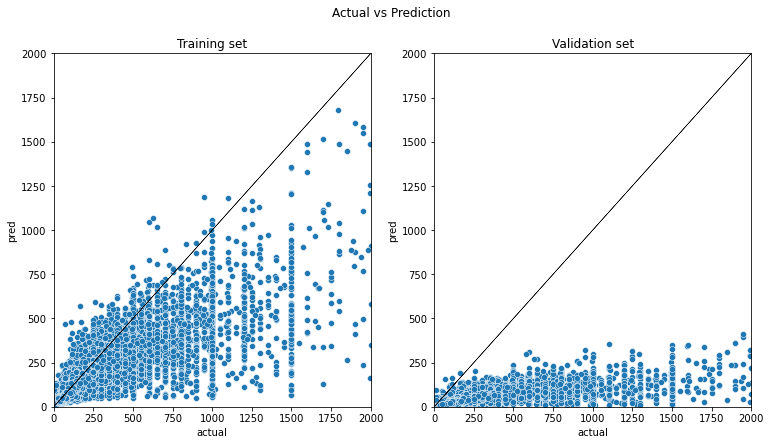

In [28]:
fig = plt.figure(figsize=(12.5, 6.5))
plt.suptitle('Actual vs Prediction')

plt.subplot(1, 2, 1)
ax = sns.scatterplot(pred_train['actual'], pred_train['pred'])
plt.plot(pred_train['actual'], pred_train['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_title('Training set');
# plt.axes().set_aspect('equal')
plt.subplot(1, 2, 2)
ax = sns.scatterplot(pred_valid['actual'], pred_valid['pred'])
plt.plot(pred_valid['actual'], pred_valid['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
plt.title('Validation set');

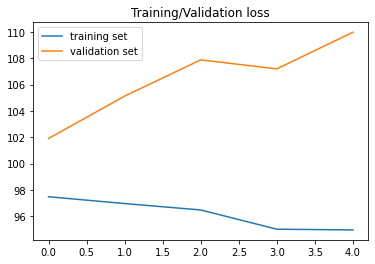

In [29]:
plt.plot(metrics['train_losses'], label='training set')
plt.plot(metrics['valid_losses'], label='validation set')
plt.title('Training/Validation loss')
plt.legend();

# Submission

In [30]:
pred_test_dfs = [pd.read_csv(os.path.join(output_dir, f'cv_fold{i + 1}_test.csv')) for i in range(N_SPLITS)]

In [31]:
pred_test = pd.concat(pred_test_dfs).groupby('id').sum()
pred_test = pred_test / N_SPLITS

In [32]:
pred_test.to_csv(os.path.join(output_dir, f'{EXPERIMENT}_submission.csv'), header=None)

# Visualization

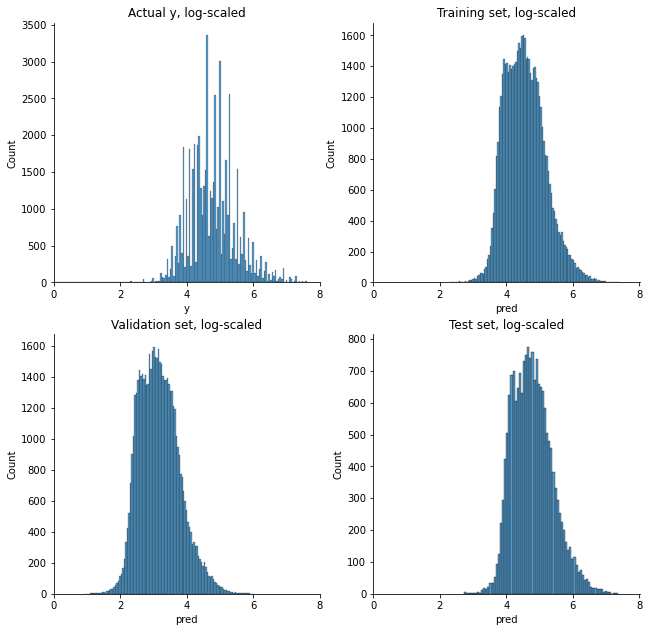

In [33]:
ylim_min, ylim_max = np.log(y_min * CLIP_LOWER_RATE), np.log(y_max * CLIP_UPPER_RATE)
fig = plt.figure(figsize=(10.5, 10.5))
plt.subplot(2, 2, 1)
ax = sns.histplot(y_log)
ax.set_title('Actual y, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 2)
ax = sns.histplot(np.log(pred_train['pred']))
ax.set_title('Training set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 3)
ax = sns.histplot(np.log(pred_valid['pred']))
ax.set_title('Validation set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 4)
ax = sns.histplot(np.log(pred_test['pred']))
ax.set_title('Test set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

fig.savefig(os.path.join(output_dir, 'figure.png'))

In [34]:
logger.debug('Complete({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Feature importance

In [35]:
pd.options.display.float_format = '{:.5f}'.format

In [36]:
models = []
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1

    ## モデルの保存
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'rb') as f:
        model = pickle.load(f)
    models.append(model)

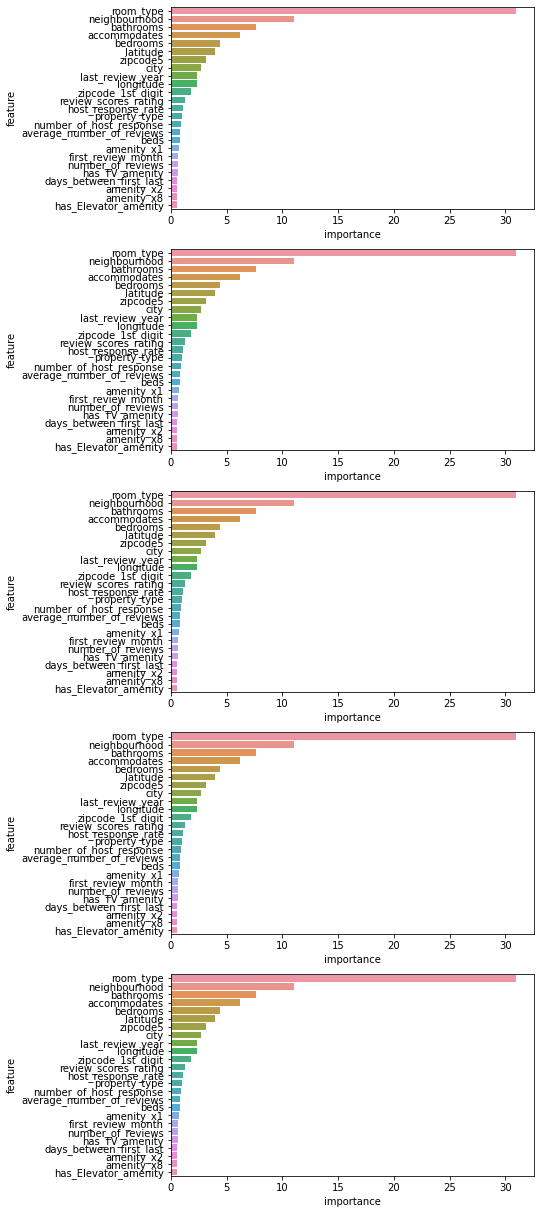

In [37]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model.feature_importances_, columns=['importance'])
    imp_df['feature'] = model.feature_names_
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance.png'))

# Error

In [38]:
pred_valid = pd.read_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [39]:
pred_valid['diff'] = pred_valid['pred'] - pred_valid['actual']

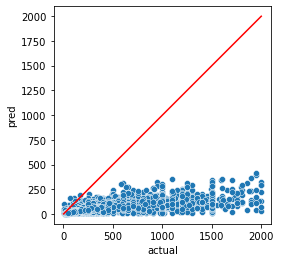

In [40]:
fig = plt.figure()
plt.axes().set_aspect('equal')
ax = sns.scatterplot(data=pred_valid, x='actual', y='pred')
ax = sns.lineplot(data=pred_valid, x='actual', y='actual', color='red')
fig.savefig(os.path.join(output_dir, 'compare_actual_prediction.png'))

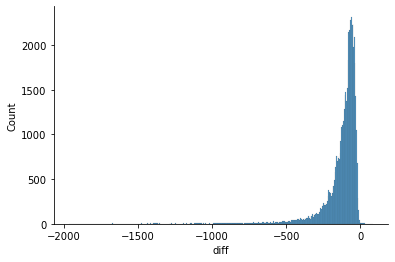

In [41]:
pred_valid.describe()
sns.histplot(data=pred_valid, x='diff')
sns.despine()

In [42]:
diff_df = pd.merge(X, pred_valid[['id', 'diff']]).set_index('id')

In [43]:
%%time
import sweetviz
report = sweetviz.analyze(diff_df, target_feat='diff', pairwise_analysis='off')
report.show_html(os.path.join(output_dir, ('sweetviz_error_report.html')))

                                             |                                             | [  0%]   00:00 ->…

Report C:\Users\nndropout\aiquest2021-assesment\experiments\02-07\sweetviz_error_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Wall time: 1min 9s


In [44]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = diff_df.shape[1]

In [45]:
diff_df.sort_values('diff').head(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [46]:
diff_df.sort_values('diff').tail(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [47]:
diff_df.corr()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [48]:
diff_df.corr().sort_values('diff')['diff'].head(50)

accommodates                             -0.47809
bedrooms                                 -0.45390
bathrooms                                -0.41891
beds                                     -0.39727
room_type                                -0.26893
has_Familykid-friendly_amenity           -0.19138
has_Indoor-fireplace_amenity             -0.16721
has_TV_amenity                           -0.16133
has_Cable-TV_amenity                     -0.15569
has_Dryer_amenity                        -0.14266
has_Washer_amenity                       -0.13965
amenity_x1                               -0.13700
has_Suitable-for-events_amenity          -0.13627
amenity_x3                               -0.11447
has_thumbnail                            -0.11222
has_Hot-tub_amenity                      -0.07681
has_Gym_amenity                          -0.07583
has_Pool_amenity                         -0.07341
has_Doorman_amenity                      -0.07093
has_Free-parking-on-premises_amenity     -0.06650


In [49]:
from lightgbm import LGBMRegressor
estimator = LGBMRegressor(random_state=SEED, n_jobs=-1, importance_type='gain').fit(diff_df.drop(columns=['diff']), diff_df['diff'])

In [50]:
imp_df = pd.DataFrame(data=estimator.feature_importances_, columns=['importance'])

In [51]:
imp_df['feature'] = estimator.feature_name_

In [52]:
imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
imp_df.head(25)

,importance,feature
3,996155224.19531,bedrooms
1,618376487.20312,bathrooms
0,519463864.60156,accommodates
13,296311258.70312,longitude
12,273753407.19531,latitude
18,248130861.89844,room_type
155,120292102.10156,last_review_year
144,74846697.60156,average_number_of_reviews
17,51828557.00000,review_scores_rating
10,47228103.00000,host_response_rate


In [53]:
imp_df.to_csv(os.path.join(output_dir, 'diff_feature_importances.csv'), index=False)